In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download eswarchandt/amazon-music-reviews

Dataset URL: https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews
License(s): CC0-1.0
  0% 0.00/4.69M [00:00<?, ?B/s]
100% 4.69M/4.69M [00:00<00:00, 142MB/s]


In [ ]:
import zipfile
zip_ref =  zipfile.ZipFile(r'/content/amazon-music-reviews.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 31.0 MB/s eta 0:00:00


# Introduction

The rise of e-commerce has made customer reviews a critical aspect of product analysis, offering valuable insights into user experiences and expectations. This project focuses on analyzing **negative reviews** from the [Amazon Music Reviews dataset](https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews) to identify recurring issues and concerns related to music accessories and instruments. Using a combination of **Natural Language Processing (NLP)** and **clustering techniques**, the goal was to group negative reviews into meaningful clusters that can provide actionable insights for manufacturers and sellers.

The project involves a comprehensive workflow:
1. **Data preprocessing**: Cleaning and preparing textual data for analysis using `spaCy`.
2. **Sentiment analysis**: Identifying and isolating negative reviews using the `SentimentIntensityAnalyzer`.
3. **Feature extraction**: Representing text numerically with `TfidfVectorizer`.
4. **Clustering**: Applying the K-means algorithm to uncover patterns in the reviews.

By categorizing customer grievances into distinct themes, this analysis provides a clear view of common issues with music-related products and accessories, paving the way for improvements and enhanced customer satisfaction.


### Import Libraries:

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis:

In [ ]:
df = pd.read_csv(r'/content/Musical_instruments_reviews.csv')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [9]:
nlp = spacy.load('en_core_web_sm')

# Remove URL
def remove_url(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if not token.text.startswith(('http', 'www'))]
  return ' '.join(filtered)

# Remove Emoji
def remove_emoji(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if token.is_ascii]
  return ' '.join(filtered)

# Remove Punctuation and characters
def remove_punctuation_characters(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if token.is_alpha]
  return ' '.join(filtered)

# Remove the extra space
def remove_extra_space(text):
  return ' '.join(text.split())

# Clean the Text data
def clean_text(text):
  if isinstance(text, str):
    text = text.lower()
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_punctuation_characters(text)
    text = remove_extra_space(text)
    return text

df['review'] = df['reviewText'].apply(clean_text)
df['review'].iloc[0]

'not much to write about here but it does exactly what it supposed to filters out the pop sounds now my recordings are much more crisp it is one of the lowest prices pop filters on amazon so might as well buy it they honestly work the same despite their pricing'

In [14]:
# Finding the null values
df.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0
review,7


In [15]:
# Removing the null values
df.dropna(inplace = True)
df.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,0
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
review,0


In [16]:
# Lemmatization and Remove Stop Words
def lemmatization(text):
  doc = nlp(text)
  lemmatized_token = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
  return ' '.join(lemmatized_token)

df['lemmatized_review'] = df['review'].apply(lemmatization)
df['lemmatized_review'].iloc[0]

'write exactly suppose filter pop sound recording crisp low price pop filter amazon buy honestly work despite pricing'

In [18]:
# Creating the categories for review
from nltk.sentiment.vader  import SentimentIntensityAnalyzer

# Download required functions of nltk
nltk.download('vader_lexicon')

# Creating the Sentiment object
sia = SentimentIntensityAnalyzer()

# Creating the categories
def sentiment_category(text):
  score = sia.polarity_scores(text)
  if score['compound'] >= 0.05:
    return 'positive'
  elif score['compound'] <= -0.05:
    return 'negative'
  else:
    return 'neutral'
df['sentiment'] = df['lemmatized_review'].apply(sentiment_category)
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review,lemmatized_review,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",not much to write about here but it does exact...,write exactly suppose filter pop sound recordi...,positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",the product does exactly as it should and is q...,product exactly realize double screen arrive w...,positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",the primary job of this device is to block the...,primary job device block breath produce poppin...,negative
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",nice windscreen protects my mxl mic and preven...,nice windscreen protect mxl mic prevent pop th...,positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",this pop filter is great it looks and performs...,pop filter great look perform like studio filt...,positive


In [19]:
# Taking only the negative sentiments
data = df[df['sentiment'] == 'negative']
data.head()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['lemmatized_review'])

In [21]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

# finding the optimal cluster k
for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  cluster_labels = kmeans.fit_predict(X)
  silhouette_avg = silhouette_score(X, cluster_labels)
  silhouette_scores.append(silhouette_avg)

# optimal k from the highest silhouette average score
best_k = np.argmax(silhouette_scores) + 2

print(f'The optimal cluster: {best_k}')

The optimal cluster: 7


In [26]:
# K-means clustering
num_clusters = best_k
kmeans = KMeans(n_clusters = num_clusters, random_state = 42)
kmeans.fit(X)

# Assign each review to a cluster
clusters = kmeans.predict(X)
print("Cluster Assignments:", clusters)

Cluster Assignments: [0 5 4 4 5 4 0 4 2 4 4 5 4 4 2 4 4 4 0 4 4 0 2 4 0 4 2 5 4 4 6 2 2 4 4 5 4
 4 4 4 2 1 2 2 1 4 1 4 5 5 2 2 4 0 4 0 4 5 5 2 0 0 6 2 2 2 2 2 2 2 5 2 4 6
 5 6 0 1 2 5 2 4 2 4 5 2 5 6 6 2 4 0 6 6 2 6 4 2 6 6 4 6 6 6 6 6 4 6 6 5 4
 6 6 2 4 4 4 5 5 4 2 2 5 5 4 4 0 5 6 6 5 2 4 5 4 5 5 5 4 5 0 4 4 5 0 6 6 6
 6 6 6 4 5 4 2 2 2 2 2 2 2 4 4 2 2 0 6 4 2 4 4 4 4 4 1 4 4 5 1 2 4 2 5 6 2
 6 6 6 6 4 2 1 1 1 1 5 4 6 4 4 4 4 4 2 4 4 4 5 4 4 4 4 4 2 2 2 2 5 5 6 6 2
 5 2 2 2 2 2 2 2 2 2 4 5 2 2 5 2 0 4 4 4 4 5 4 4 2 0 4 4 1 2 5 2 4 0 1 4 1
 1 4 6 0 5 0 2 0 3 1 5 1 1 2 2 5 5 5 4 4 4 2 6 4 4 4 1 1 1 1 2 5 5 2 6 6 6
 3 0 4 6 5 4 3 3 5 4 4 1 5 4 5 4 4 5 2 0 4 4 0 4 3 4 4 2 2 4 5 4 3 4 3 2 2
 6 2 2 4 2 6 6 6 6 6 2 4 1 4 5 4 5 3 2 5 4 4 0 4 4 4 0 4 0 4 0 0 5 6 2 5 2
 4 4 5 4 0 0 2 2 6 4 4 4 5 0 0 5 5 4 4 2 0 4 0 4 5 2 2 4 2 5 4 4 4 5 0 4 4
 4 2 4 1 1 1 1 4 4 4 4 4 0 0 2 5 4 6 5 5 2 4 5 4 4 4 4 2 2 4 5 5 2 2 4 4 0
 4 5 2 5 4 3 2 4 4 2 6 4 4 2 4 4 4 4 2 3 2 4 4 0 0 4 0 4 2 1 6 5 4 2 2 2 2
 4 4

In [27]:
# Top terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(", ".join(terms[ind] for ind in order_centroids[i, :10]))  # Top 10 terms


Cluster 0:
quality, sound, cable, device, plug, mic, midi, work, amp, need
Cluster 1:
strap, guitar, lock, button, leather, long, use, need, acoustic, cheap
Cluster 2:
pick, guitar, buy, hold, wrong, thing, case, bass, bad, lose
Cluster 3:
tuner, tune, battery, snark, guitar, clip, display, instrument, accurate, problem
Cluster 4:
pedal, work, cable, price, buy, get, problem, screw, ve, thing
Cluster 5:
use, stand, mic, problem, guitar, work, abuse, mount, hold, lot
Cluster 6:
string, guitar, sound, fret, time, tone, try, problem, tune, low


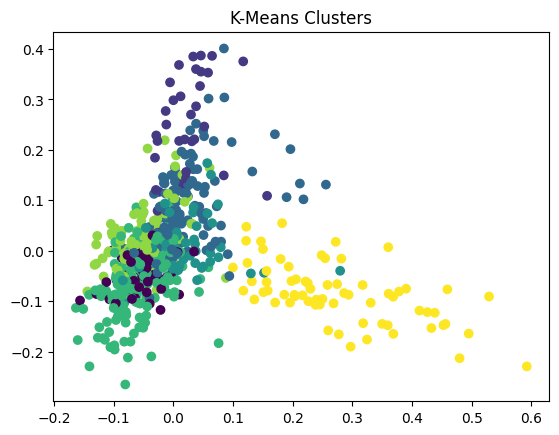

In [28]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Plot clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
plt.title("K-Means Clusters")
plt.show()

# Conclusion

The analysis of negative reviews revealed **seven key clusters**, each representing a recurring theme in customer feedback:

1. **Cluster 0**: Issues with **sound quality and connectivity**, including problems with cables, devices, and amplifiers.
2. **Cluster 1**: Complaints related to **guitar straps**, including durability, compatibility, and usage concerns.
3. **Cluster 2**: Problems with **guitar picks**, cases, and bass accessories, often describing poor quality or mismatched expectations.
4. **Cluster 3**: Feedback on **tuners**, with mentions of battery life, display accuracy, and clip reliability.
5. **Cluster 4**: Issues with **pedals and cables**, focusing on functionality, price, and durability.
6. **Cluster 5**: Complaints about **stands and mounts**, emphasizing stability, usability, and frequent breakdowns.
7. **Cluster 6**: Concerns about **guitar strings and sound quality**, including tone, tuning, and fret issues.

These clusters highlight the specific areas where manufacturers can focus their efforts to address user dissatisfaction:
- **Quality Assurance**: Ensuring consistent performance of tuners, cables, and pedals.
- **Product Design**: Improving the durability of straps, picks, and stands.
- **Customer Experience**: Enhancing user guides and support for resolving common problems.

By acting on these insights, businesses can improve product quality and enhance customer satisfaction, ultimately driving better reviews and sales performance.